In [167]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import csv
# from google.colab import files
# import io
# import glob


In [181]:
# df_main_ar = [pd.read_csv(io.BytesIO(uploaded[d])) for d in uploaded]
# path = r'./data' # use your path
# all_files = glob.glob(path + "/*.csv")

# li = {}
# li = []
# for filename in all_files:
#     df = pd.read_csv(filename, index_col=None, header=0)
#     name = filename.split("/")[2][7:-4]
#     # li[name] = (df)
#     li.append(df)

AddressCount = pd.read_csv("./data/export-AddressCount.csv", index_col=None, header=0)
DAU = pd.read_csv("./data/export-DailyActiveEthAddress.csv", index_col=None, header=0)
MarCap = pd.read_csv("./data/export-MarketCap.csv", index_col=None, header=0)
NetHash = pd.read_csv("./data/export-NetworkHash.csv", index_col=None, header=0)
DailyTx = pd.read_csv("./data/export-TxGrowth.csv", index_col=None, header=0)
Fees = pd.read_csv("./data/export-TransactionFee.csv", index_col=None, header=0)
AVGFee = pd.read_csv("./data/export-AverageDailyTransactionFee.csv", index_col=None, header=0)
RealMC = pd.read_csv("./data/Coin_Metrics_Network_Data_2022-06-27T17-17.csv",  sep = ";", index_col=None, header=0)

# RealMC.drop('Time',axis = 1, inplace = True)[:-10]


AddressCount = AddressCount.rename(columns={"Value":"AddressCount"})
NetHash = NetHash.rename(columns={"Value":"NetHash"})
DailyTx = DailyTx.rename(columns={"Value":"DailyTx"})
Fees = Fees.rename(columns={"Value":"Fees"})

DAU.drop('Date(UTC)',axis = 1, inplace = True)
AVGFee.drop('Date(UTC)',axis = 1, inplace = True)
AVGFee.drop('UnixTimeStamp',axis = 1, inplace = True)
AVGFee.drop('DateTime',axis = 1, inplace = True)

frame = pd.concat([AddressCount, DAU,MarCap, NetHash, DailyTx, AVGFee, RealMC[:-10]], axis=1)
# frame.rename(columns={frame.columns[3]:'Drop'}, inplace=True)
frame = frame.T.drop_duplicates().T
frame.drop('Time',axis = 1, inplace = True)
frame['Date(UTC)'] = frame['Date(UTC)'].apply(pd.to_datetime)
frame['newAddressCount'] = frame['AddressCount'].diff()
frame.rename(columns={'ETH / Realized Market Cap (USD)':'rCap'}, inplace=True)
# frame[''] = frame['ETH / Realized Market Cap (USD)']
# frame.drop('Drop',axis = 1, inplace = True)
frame = frame
print(RealMC.shape)

(2524, 2)


In [182]:
frame

,Date(UTC),UnixTimeStamp,AddressCount,Unique Address Total Count,Unique Address Receive Count,Unique Address Sent Count,Supply,MarketCap,Price,NetHash,DailyTx,Average Txn Fee (USD),Average Txn Fee (Ether),rCap,newAddressCount
0,2015-07-30,1438214400,9205,8894,1,8893,72049306.59375,0.0,0.00,11.5297,8893,0.0,0,0.0,NaN
1,2015-07-31,1438300800,9361,0,0,0,72085498.3125,0.0,0.00,51.4594,0,0.0,0,0.0,156
2,2015-08-01,1438387200,9476,0,0,0,72113204.25,0.0,0.00,57.7845,0,0.0,0,0.0,115
3,2015-08-02,1438473600,9563,0,0,0,72141427.6875,0.0,0.00,67.9224,0,0.0,0,0.0,87
4,2015-08-03,1438560000,9639,0,0,0,72169404.40625,0.0,0.00,74.5737,0,0.0,0,0.0,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2509,2022-06-12,1654992000,198481419,424933,309592,237694,121149953.40625,173731.456184,"1,434.02",1060942.6495,1021635,4.79,0,185445830735.311493,76799
2510,2022-06-13,1655078400,198566329,452643,308584,288743,121162209.59375,146499.650864,"1,209.12",1042559.2551,1109435,9.6,0,179672636744.82486,84910
2511,2022-06-14,1655164800,198650563,455396,311696,285966,121174326.34375,146250.141437,"1,206.94",1007032.974,1086757,6.62,0,178782919739.297852,84234
2512,2022-06-15,1655251200,198729526,449772,312591,273115,121186416.28125,149894.266434,"1,236.89",961544.4888,1097000,7.34,0,178037521140.906738,78963


In [82]:
def cleanData(data):
    result = data.copy().loc[:, frame.columns!='Date(UTC)']
    result = result.loc[:, result.columns!='Price'].astype(float)
    return result

In [46]:
#  positive n --> column shifts up (todays metric to future market cap (m : 1,2,3,4,5, c : a,b,c,d) 1->b)
#  negative n --> column shifts down (todays metric to past market cap (m : 1,2,3,4,5, c : a,b,c,d) 2->a)
def shift_(cur, c, n):
    df = cur.copy()
    if (n>0):
        df[c] = df[c].shift(-n)
        return df[:-n]
    elif(n<0):
        df[c] = df[c].shift(-n)
        return df[-n:]
    else:
        return df


In [83]:
#Test shift
shift_(cleanData(frame)[30:],'MarketCap', 2)
# 33 -  1.441066e+09		- 98.456772

,UnixTimeStamp,AddressCount,Unique Address Total Count,Unique Address Receive Count,Unique Address Sent Count,Supply,MarketCap,NetHash,DailyTx,Average Txn Fee (USD),Average Txn Fee (Ether),newAddressCount
30,1.440806e+09,18815.0,1376.0,839.0,1248.0,7.286785e+07,98.429309,3.514530e+02,4139.0,0.00,0.0,128.0
31,1.440893e+09,19017.0,1625.0,931.0,1495.0,7.288931e+07,98.456772,3.401440e+02,4572.0,0.00,0.0,202.0
32,1.440979e+09,19168.0,1516.0,947.0,1386.0,7.291060e+07,94.104636,3.593523e+02,5196.0,0.00,0.0,151.0
33,1.441066e+09,19349.0,1556.0,916.0,1432.0,7.293094e+07,91.938056,3.634134e+02,5153.0,0.00,0.0,181.0
34,1.441152e+09,19500.0,1515.0,875.0,1400.0,7.294933e+07,92.697037,3.559032e+02,5195.0,0.00,0.0,151.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2507,1.654819e+09,198328057.0,453004.0,340372.0,259603.0,1.211254e+08,173731.456184,1.059067e+06,1079448.0,8.36,0.0,81125.0
2508,1.654906e+09,198404620.0,452227.0,333462.0,252434.0,1.211377e+08,146499.650864,1.062624e+06,1031618.0,5.53,0.0,76563.0
2509,1.654992e+09,198481419.0,424933.0,309592.0,237694.0,1.211500e+08,146250.141437,1.060943e+06,1021635.0,4.79,0.0,76799.0
2510,1.655078e+09,198566329.0,452643.0,308584.0,288743.0,1.211622e+08,149894.266434,1.042559e+06,1109435.0,9.60,0.0,84910.0


In [123]:
def corrDict(data, col, r, years):
    # frame[['Unique Address Total Count','MarketCap']]
    arr = {}
    for i in range(r[0], r[1]):
        # cur = pd.concat([shift_(tmp, 'MarketCap', i).corr()['MarketCap'],cur], axis = 1)
        index = i
        arr[index] = cleanData(shift_(data, col, index).loc[(data['Date(UTC)'].dt.year >= years[0]) & (data['Date(UTC)'].dt.year <= years[1])]).corr()[col]
    # cur
    return pd.DataFrame.from_dict(arr).T
corrDict(frame, 'MarketCap', (-100,100), [2017, 2022])

,UnixTimeStamp,AddressCount,Unique Address Total Count,Unique Address Receive Count,Unique Address Sent Count,Supply,MarketCap,NetHash,DailyTx,Average Txn Fee (USD),Average Txn Fee (Ether),newAddressCount
-100,0.697455,0.765121,0.627017,0.627590,0.501818,0.650373,1.0,0.943451,0.565185,0.658338,NaN,0.149814
-99,0.697920,0.765646,0.628540,0.628806,0.503736,0.650799,1.0,0.943481,0.566608,0.660679,NaN,0.151770
-98,0.698352,0.766134,0.630393,0.630498,0.505555,0.651197,1.0,0.943366,0.568089,0.663444,NaN,0.153709
-97,0.698769,0.766606,0.631968,0.631819,0.507526,0.651582,1.0,0.943335,0.569541,0.666343,NaN,0.155526
-96,0.699188,0.767078,0.633327,0.632870,0.509368,0.651969,1.0,0.943321,0.570870,0.670680,NaN,0.157206
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.725634,0.790748,0.712465,0.716019,0.630941,0.670945,1.0,0.795988,0.708961,0.742172,NaN,0.408784
96,0.725621,0.790704,0.712806,0.716629,0.630980,0.670872,1.0,0.794828,0.709650,0.739381,NaN,0.409846
97,0.725607,0.790659,0.713206,0.717176,0.630957,0.670799,1.0,0.793893,0.710087,0.735802,NaN,0.411323
98,0.725593,0.790614,0.713201,0.717583,0.630283,0.670726,1.0,0.792726,0.710260,0.732333,NaN,0.412072


plots_rcap/correlation_shifted_[2020, 2022] :-100,300.png


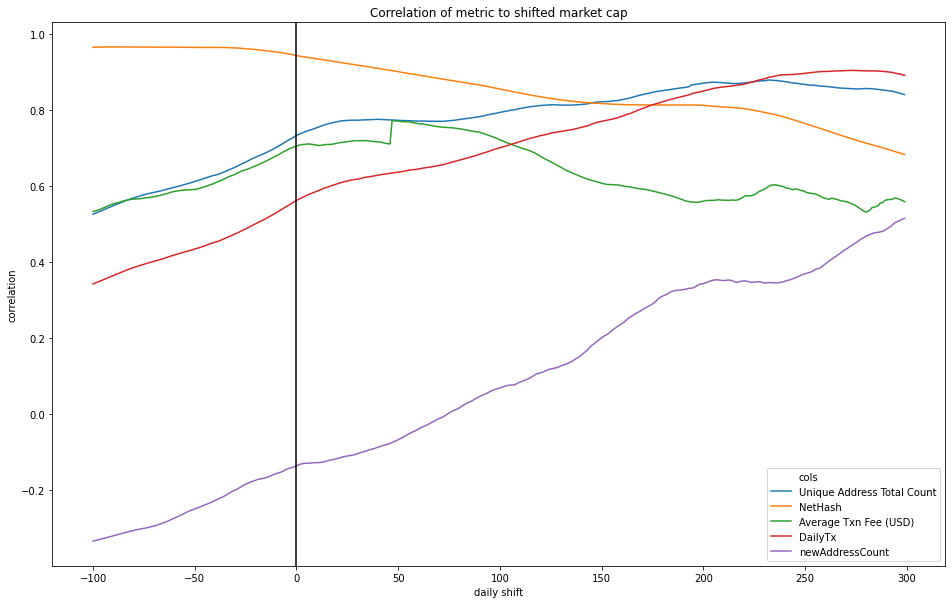

In [187]:
start_day = 0
end_day = 0
ss = -100
se = 300
target_year = [2020,2022]
condition = target_year
# cur_frame = frame[frame['Date(UTC)'].dt.year == target_year[0]].concatenate(frame[frame['Date(UTC)'].dt.year == target_year[1]], axis = 1)
arr = corrDict(frame[:], 'rCap', (ss,se), condition)[['Unique Address Total Count', 'NetHash', 'Average Txn Fee (USD)', 'DailyTx', 'newAddressCount']].reset_index()

arr_m = arr.melt('index', var_name = 'cols', value_name = 'vals')
arr_m
fig, ax = plt.subplots(figsize=(16,10))
plot = sns.lineplot(data = arr_m, x = 'index', y = 'vals',ax = ax, hue='cols')
plot.set(xlabel='daily shift', ylabel='correlation', title='Correlation of metric to shifted market cap')
plot.axvline(0, color= 'black')
name = 'plots_rcap/correlation_shifted_' + str(target_year) + ' :' + str(ss) + ',' + str(se) + '.png'
print(name)
fig.savefig(name, transparent = False)
# arr.plot(kind = 'scatter', x='index', y=['Unique Address Total Count', 'NetHash', 'Average Txn Fee (USD)'])


2020-2022/Unique Address Total Count_shifted_by_0.png
2020-2022/DailyTx_shifted_by_0.png
2020-2022/Average Txn Fee (USD)_shifted_by_0.png
2020-2022/NetHash_shifted_by_0.png
2020-2022/Unique Address Total Count_shifted_by_20.png
2020-2022/DailyTx_shifted_by_20.png
2020-2022/Average Txn Fee (USD)_shifted_by_20.png
2020-2022/NetHash_shifted_by_20.png
2020-2022/Unique Address Total Count_shifted_by_40.png
2020-2022/DailyTx_shifted_by_40.png
2020-2022/Average Txn Fee (USD)_shifted_by_40.png
2020-2022/NetHash_shifted_by_40.png
2020-2022/Unique Address Total Count_shifted_by_60.png
2020-2022/DailyTx_shifted_by_60.png
2020-2022/Average Txn Fee (USD)_shifted_by_60.png
2020-2022/NetHash_shifted_by_60.png
2020-2022/Unique Address Total Count_shifted_by_80.png
2020-2022/DailyTx_shifted_by_80.png
2020-2022/Average Txn Fee (USD)_shifted_by_80.png
2020-2022/NetHash_shifted_by_80.png
2020-2022/Unique Address Total Count_shifted_by_100.png


/Users/user/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


2020-2022/DailyTx_shifted_by_100.png
2020-2022/Average Txn Fee (USD)_shifted_by_100.png
2020-2022/NetHash_shifted_by_100.png
2020-2022/Unique Address Total Count_shifted_by_120.png
2020-2022/DailyTx_shifted_by_120.png
2020-2022/Average Txn Fee (USD)_shifted_by_120.png
2020-2022/NetHash_shifted_by_120.png
2020-2022/Unique Address Total Count_shifted_by_140.png
2020-2022/DailyTx_shifted_by_140.png
2020-2022/Average Txn Fee (USD)_shifted_by_140.png
2020-2022/NetHash_shifted_by_140.png
2020-2022/Unique Address Total Count_shifted_by_160.png
2020-2022/DailyTx_shifted_by_160.png
2020-2022/Average Txn Fee (USD)_shifted_by_160.png
2020-2022/NetHash_shifted_by_160.png
2020-2022/Unique Address Total Count_shifted_by_180.png
2020-2022/DailyTx_shifted_by_180.png
2020-2022/Average Txn Fee (USD)_shifted_by_180.png
2020-2022/NetHash_shifted_by_180.png


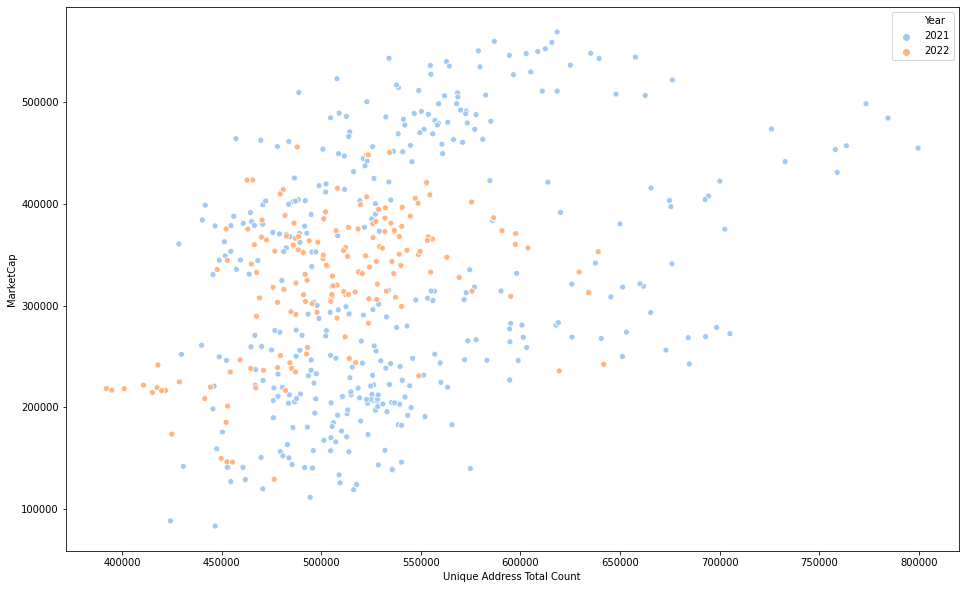

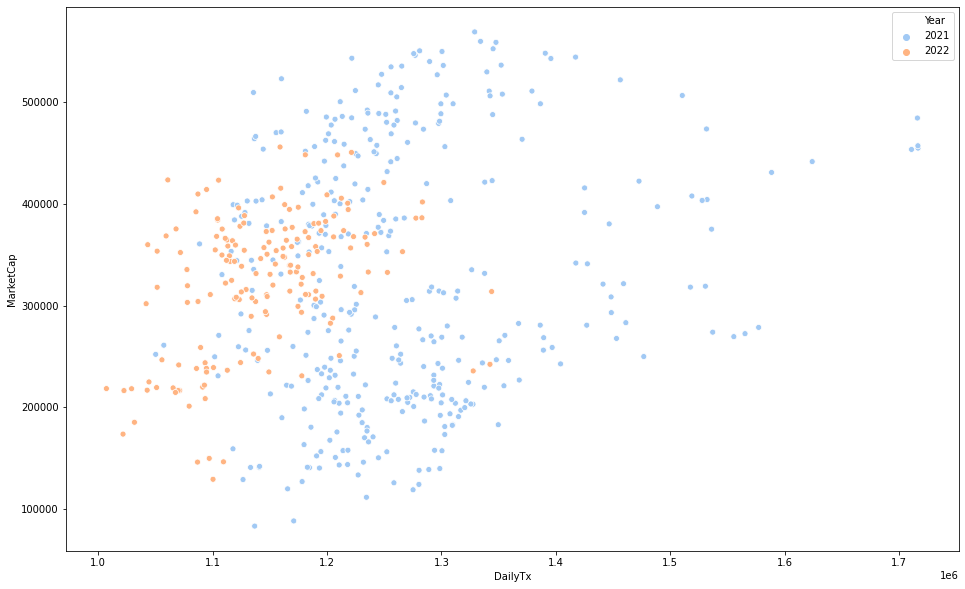

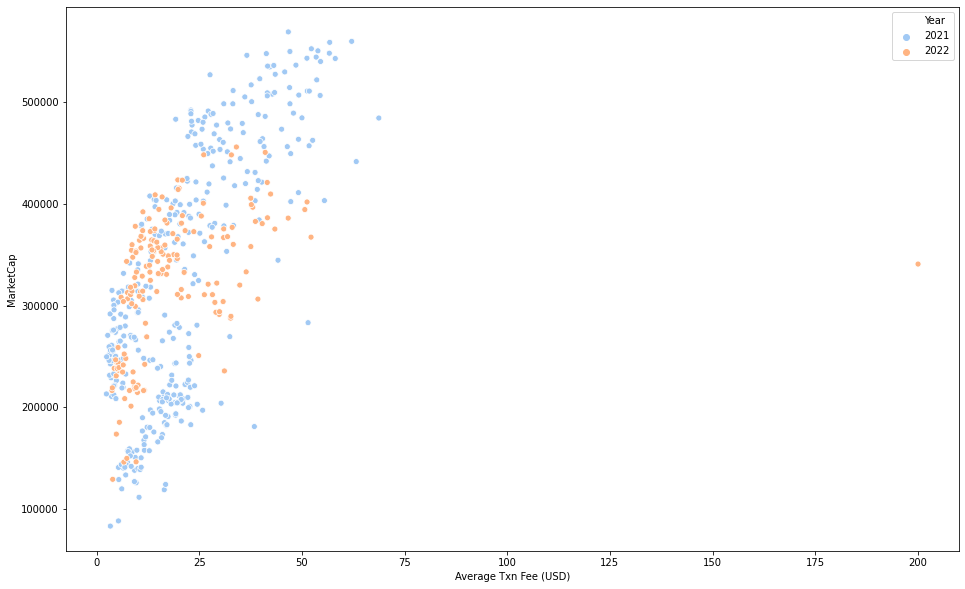

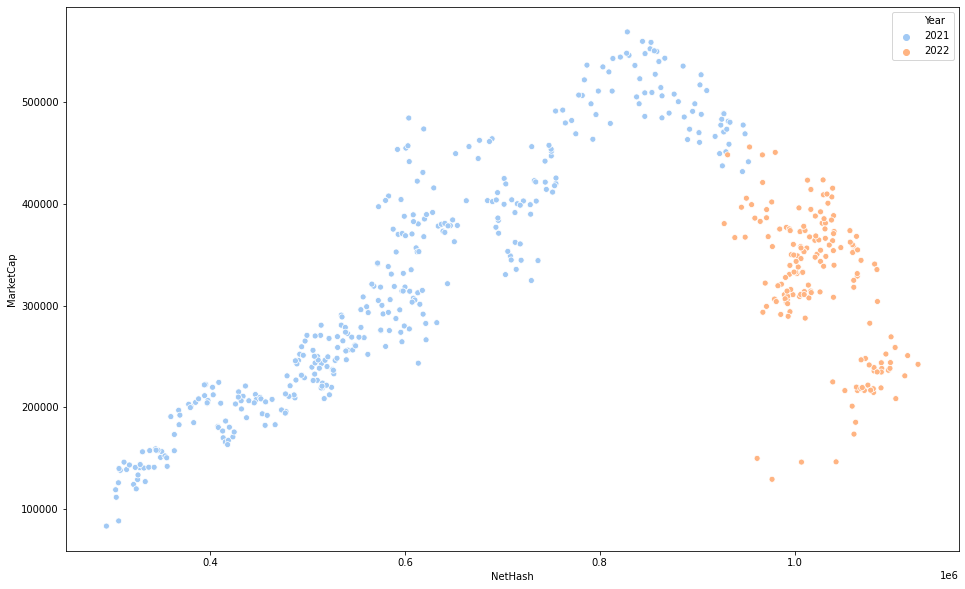

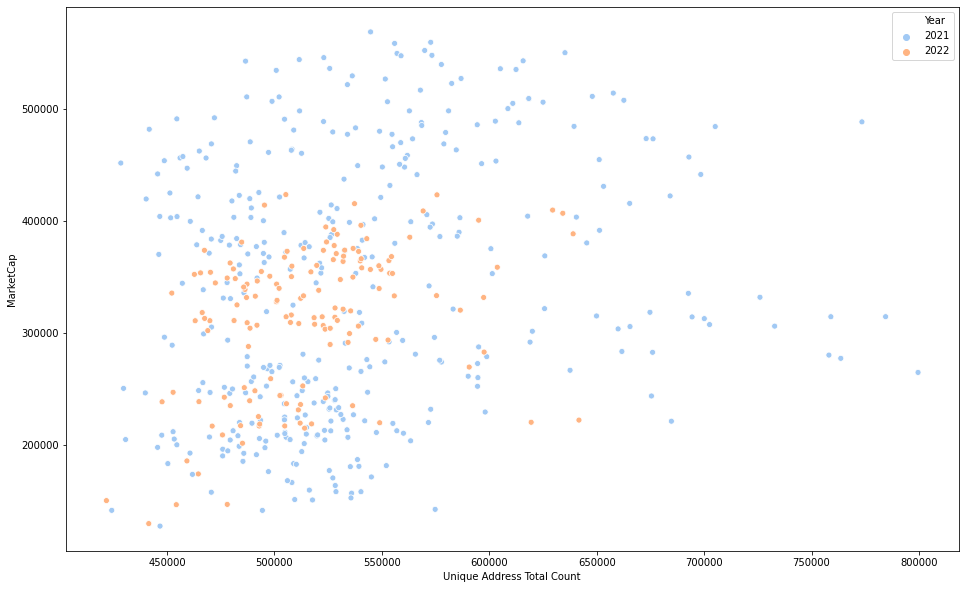

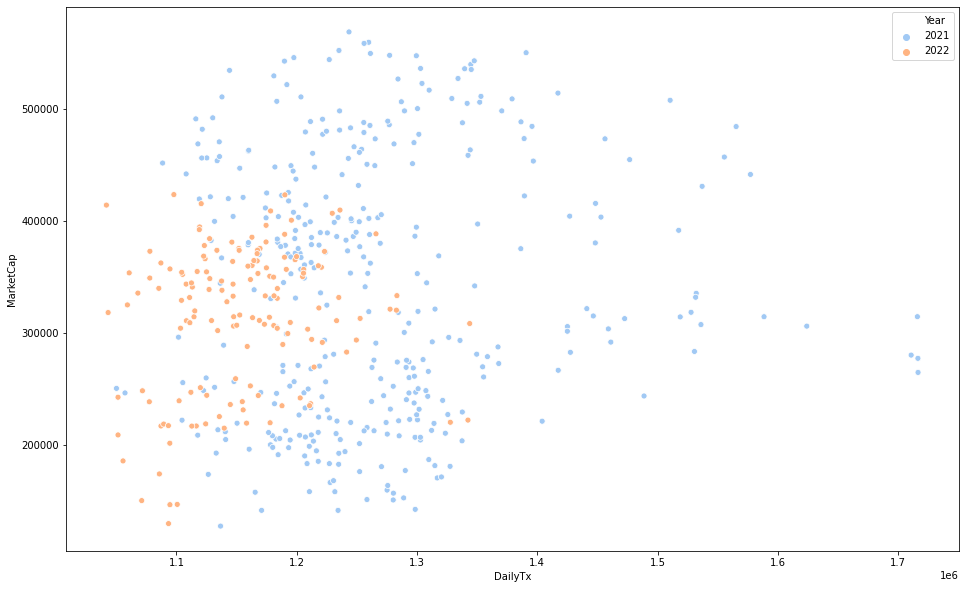

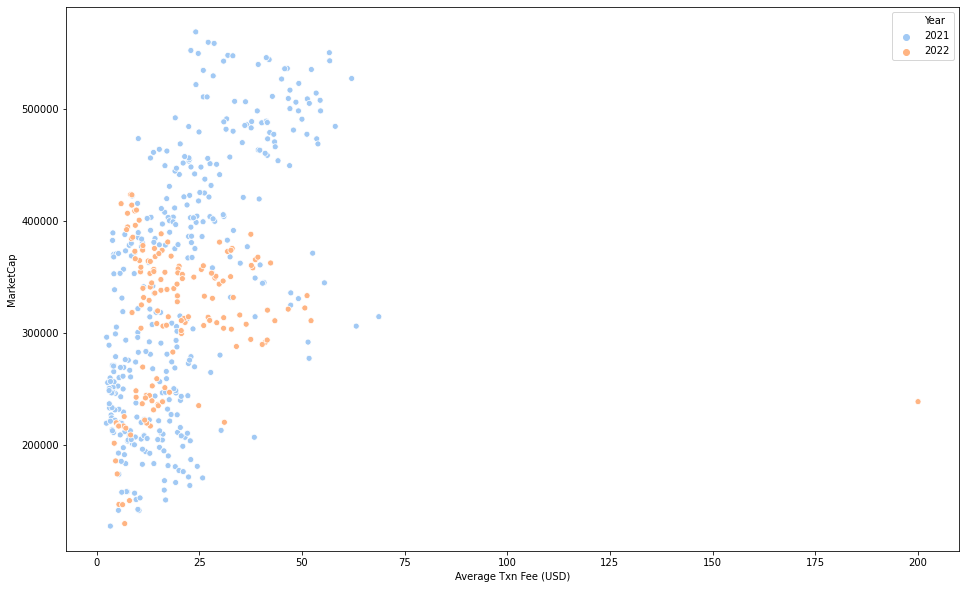

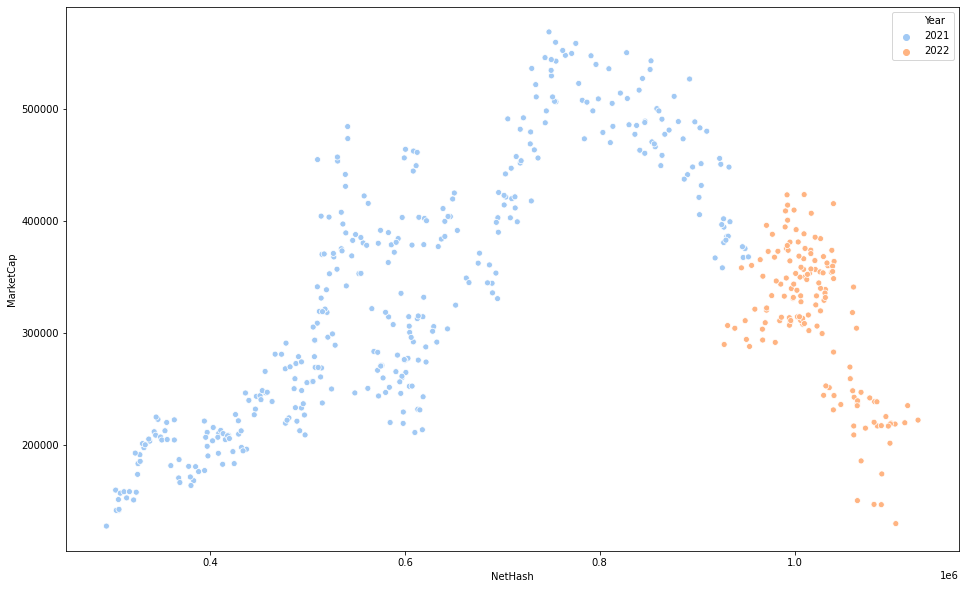

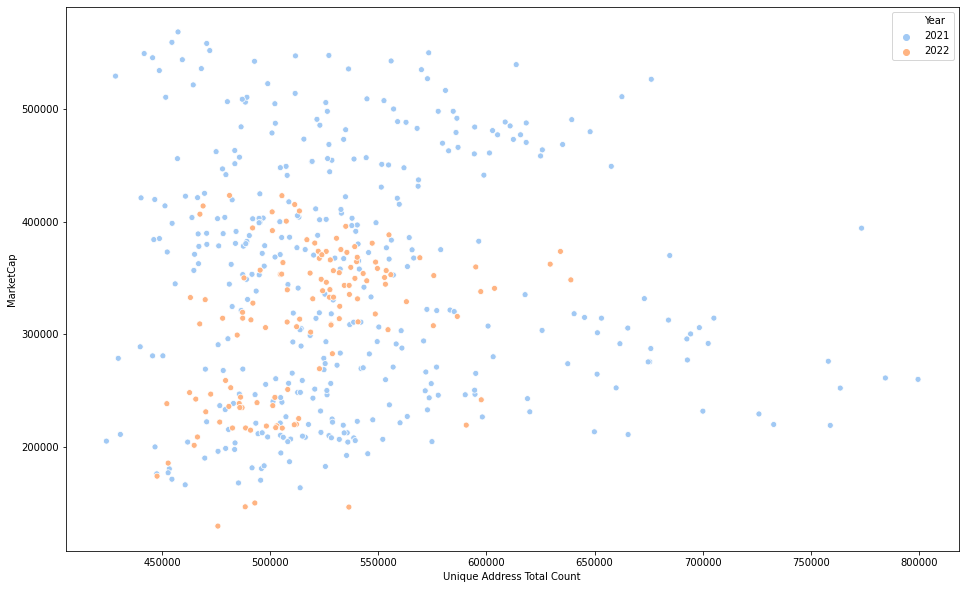

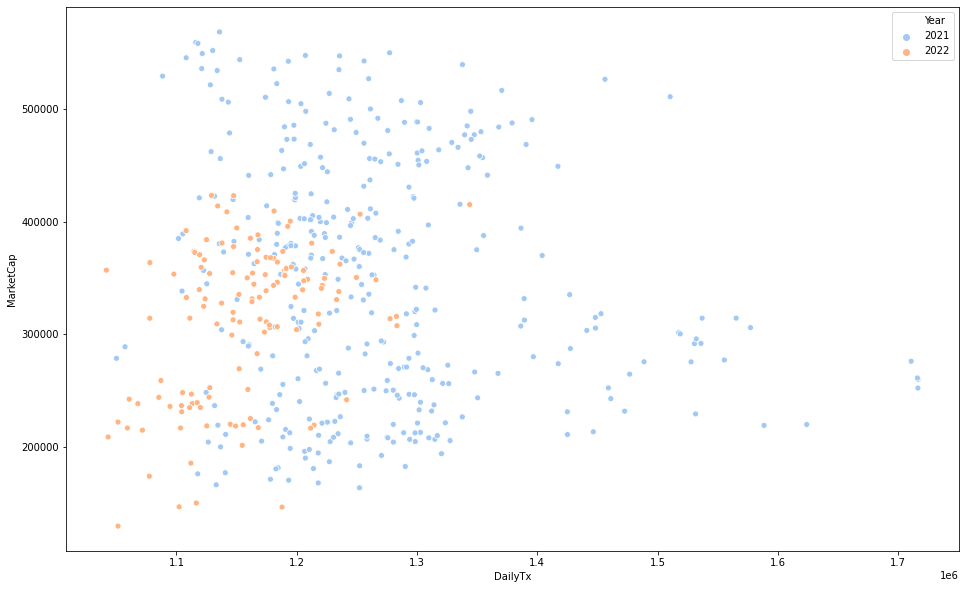

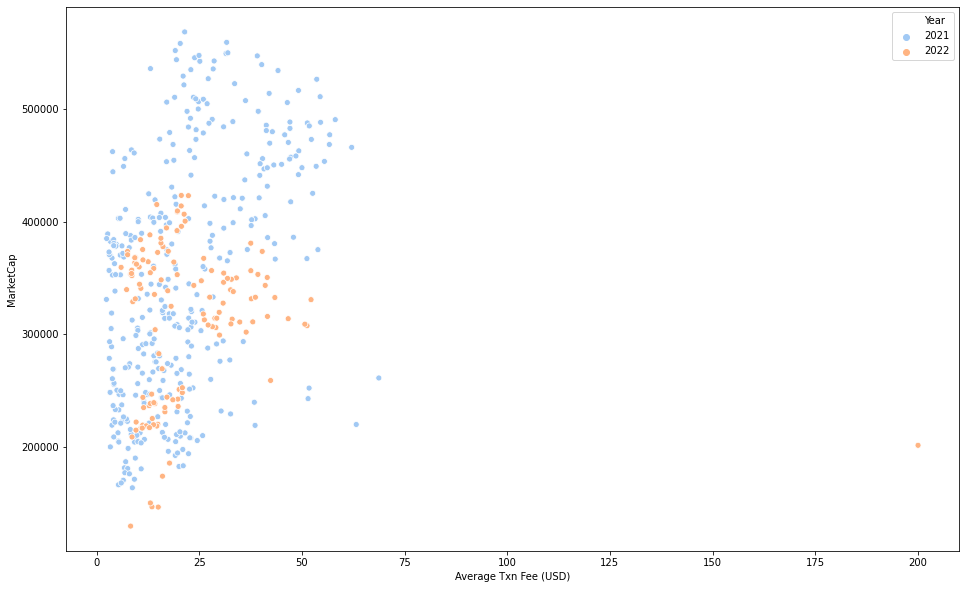

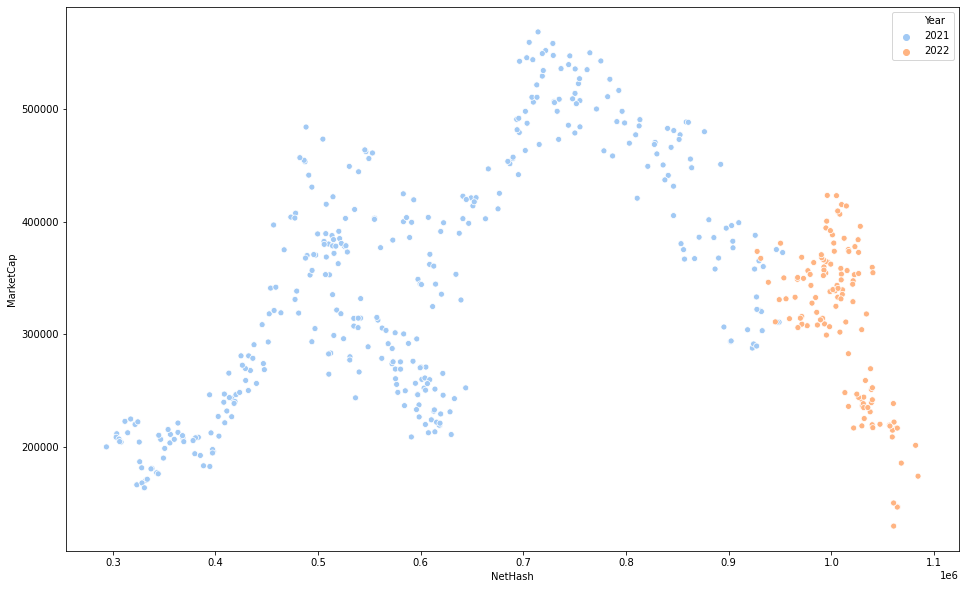

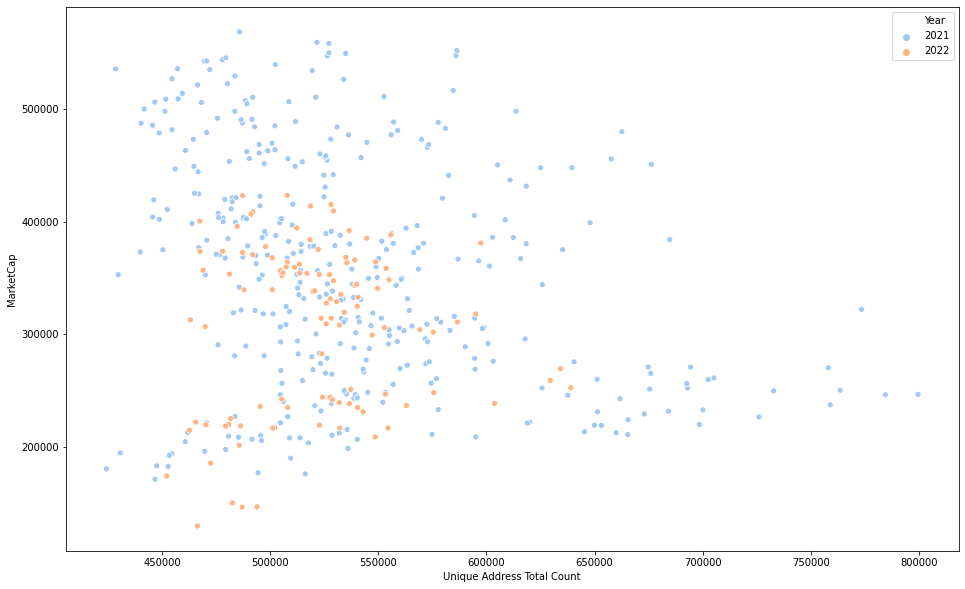

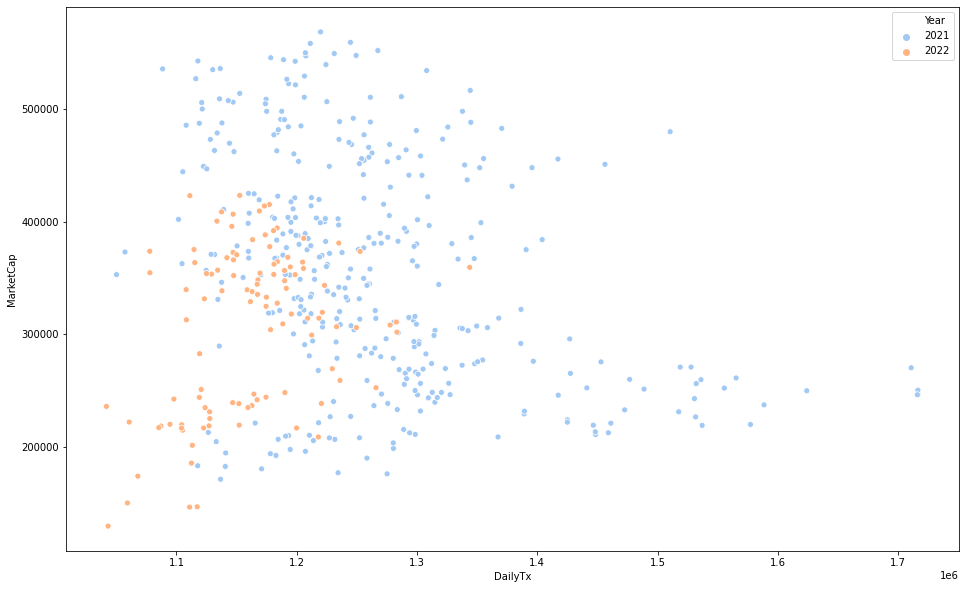

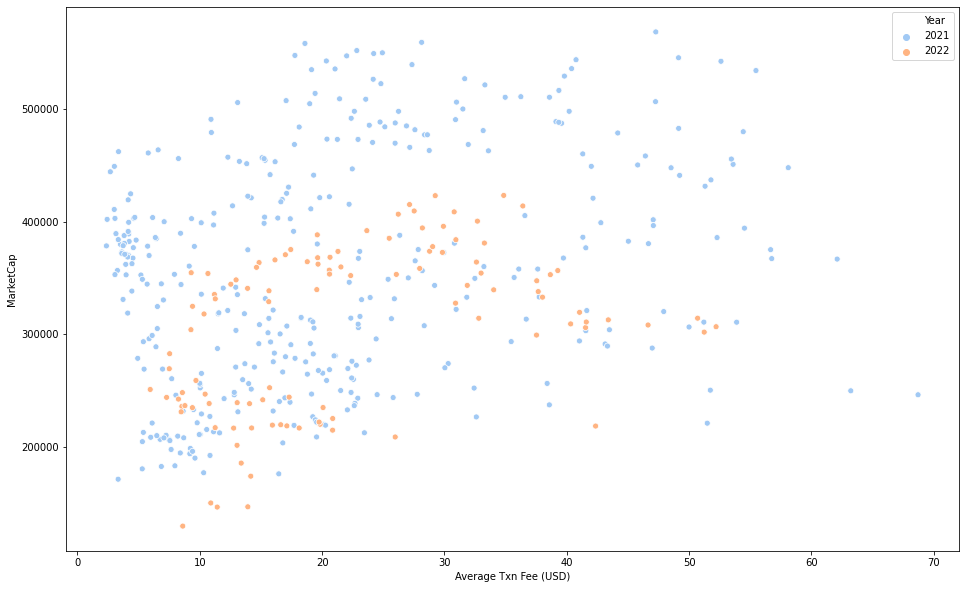

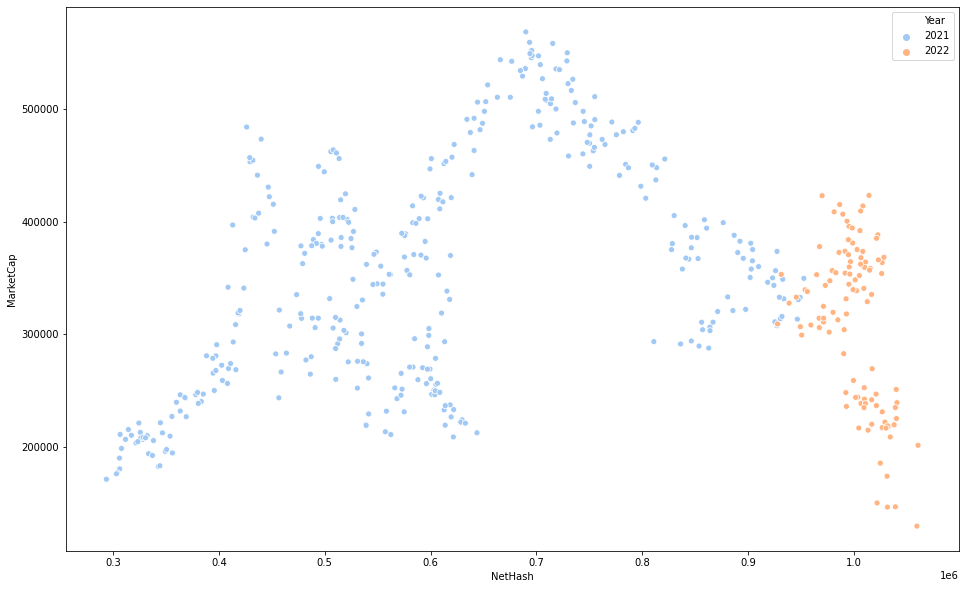

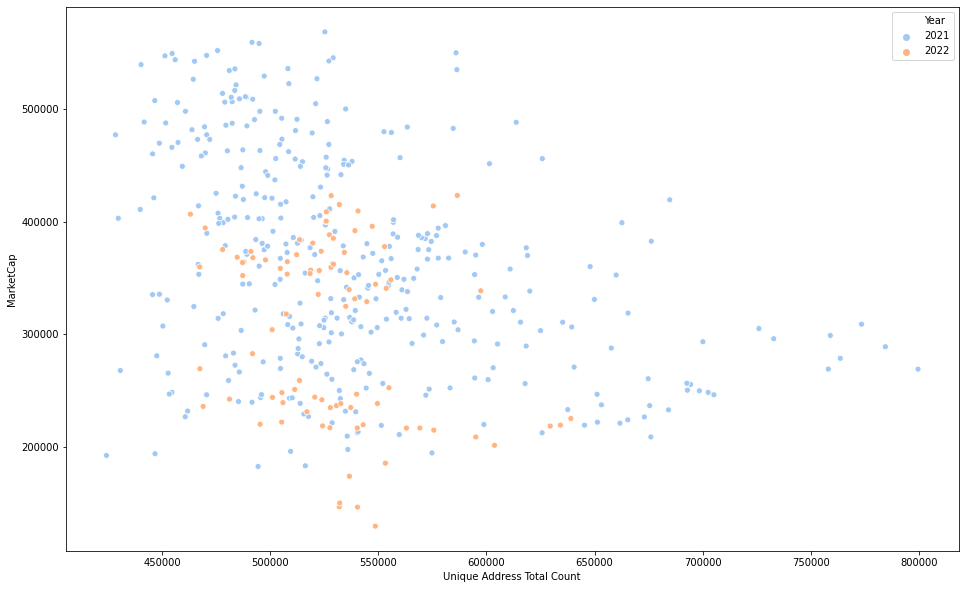

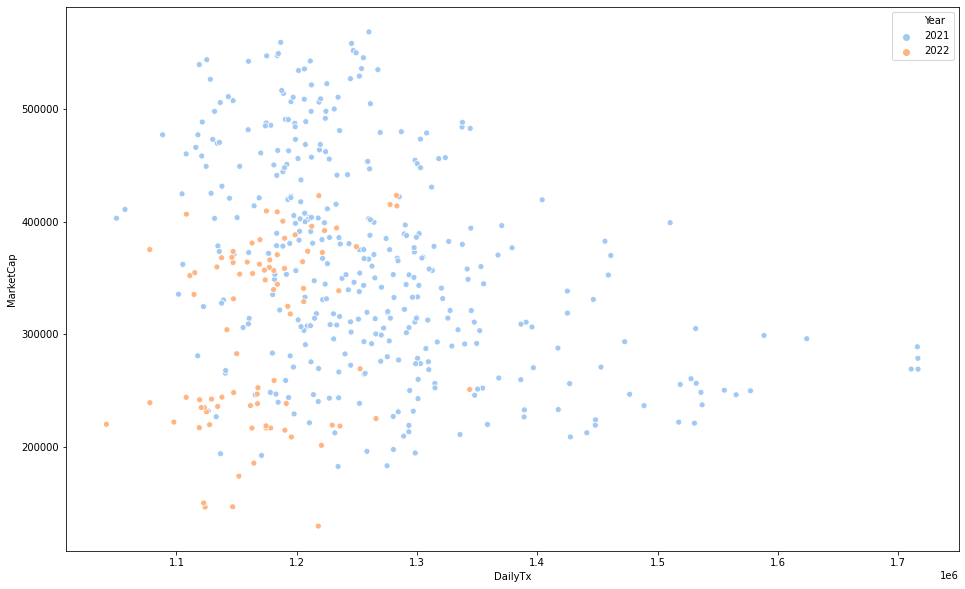

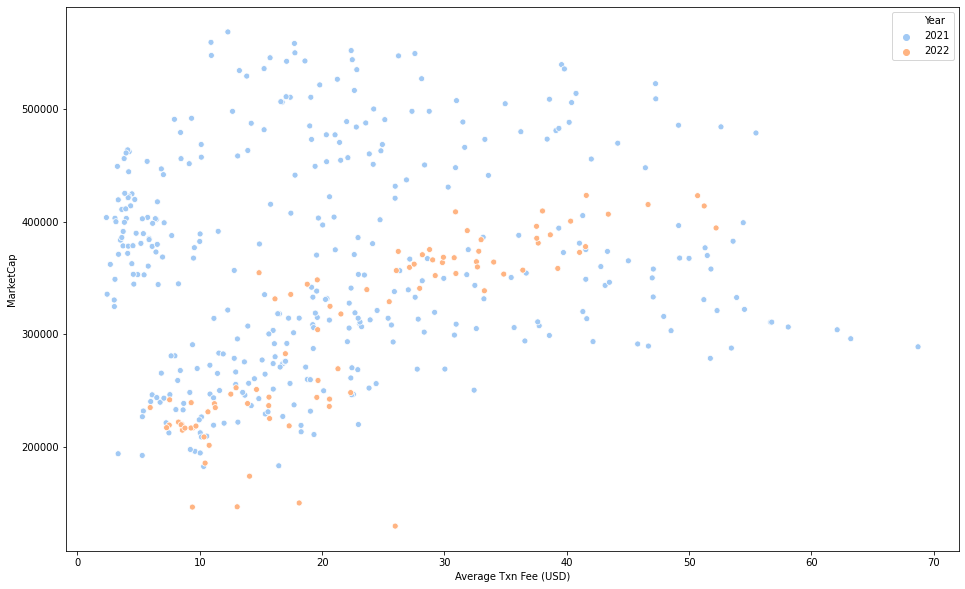

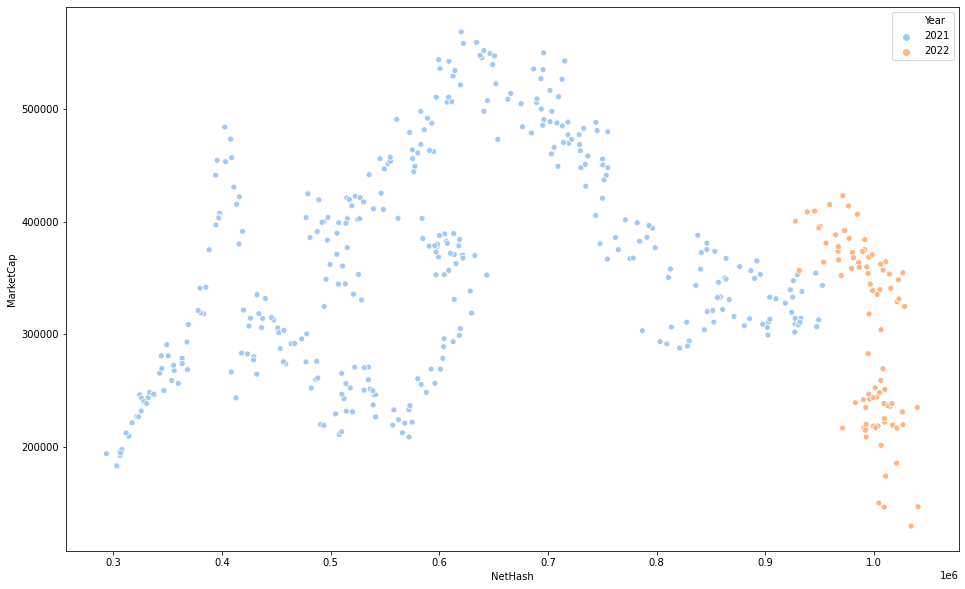

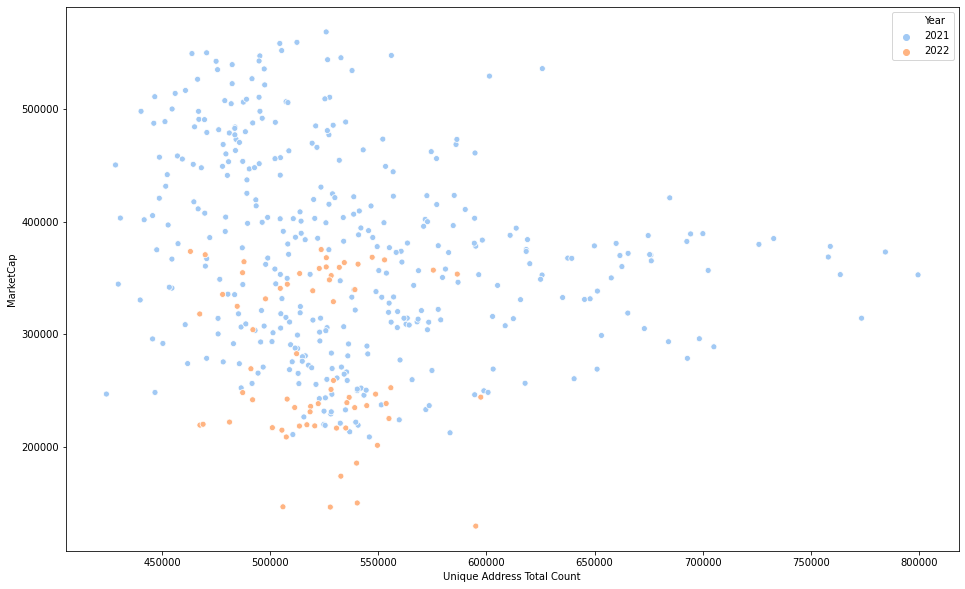

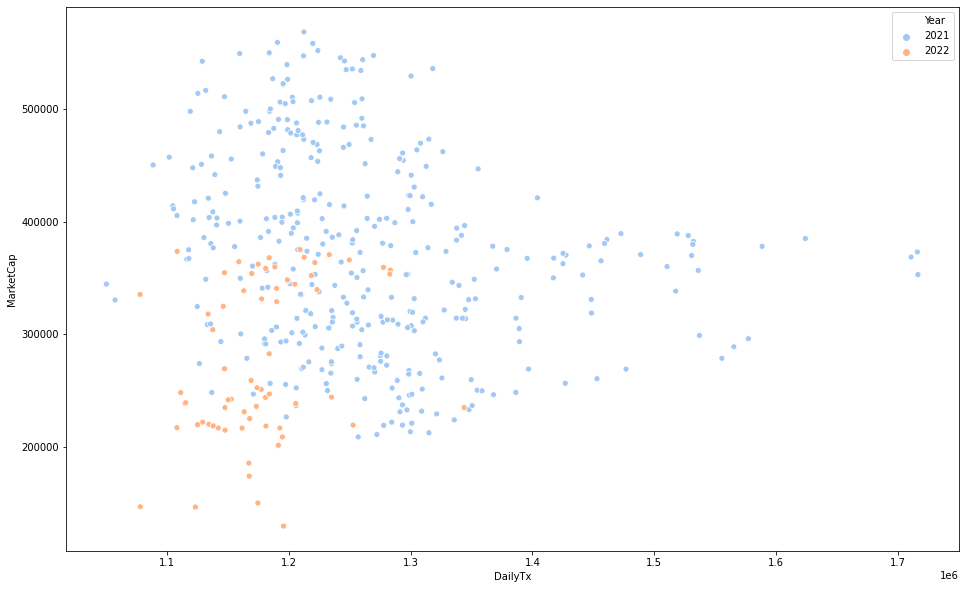

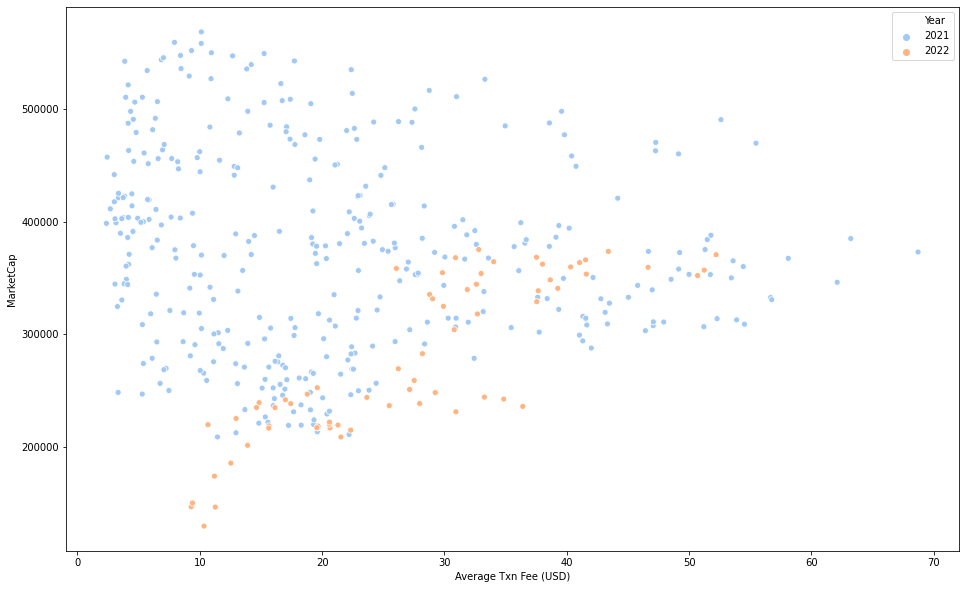

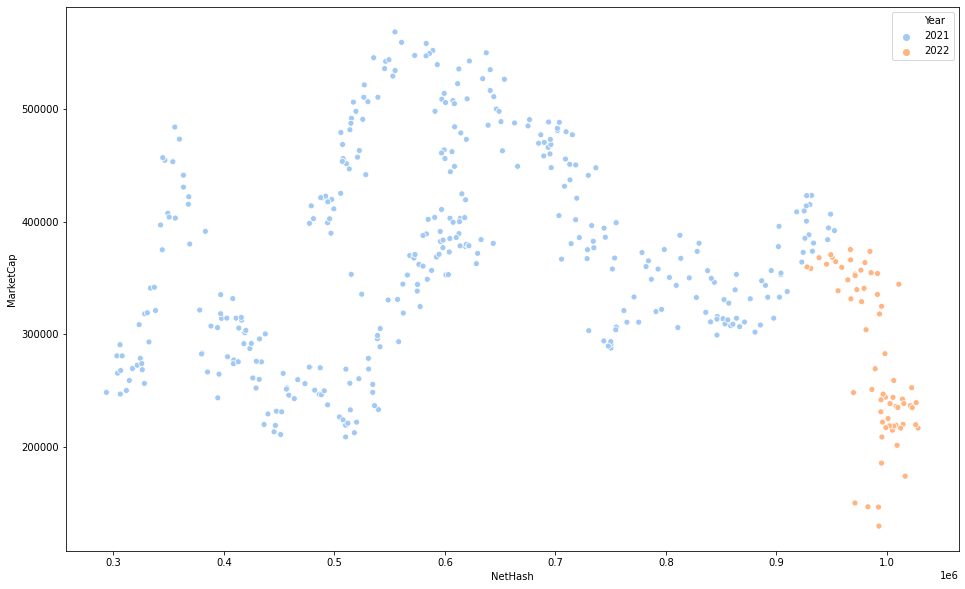

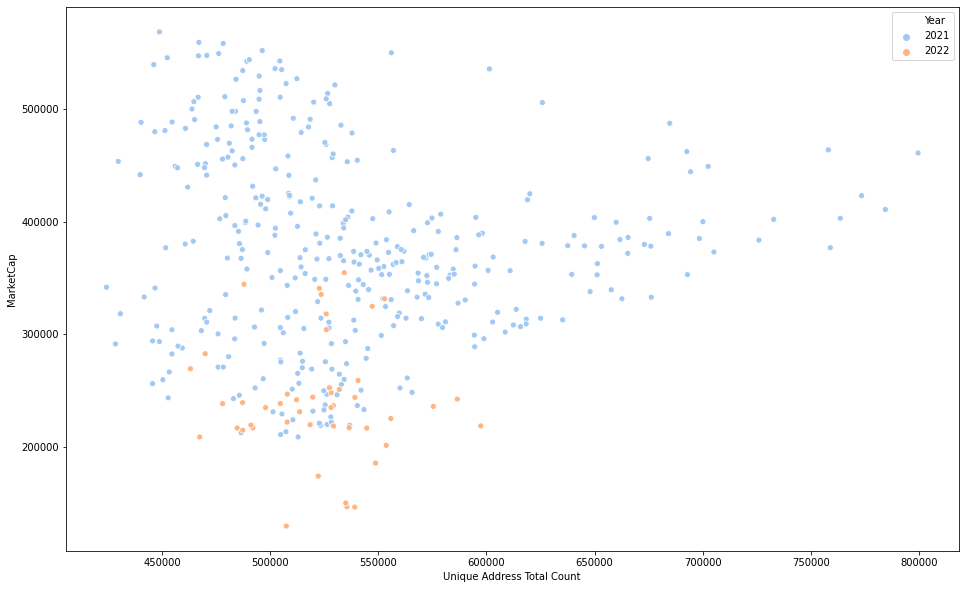

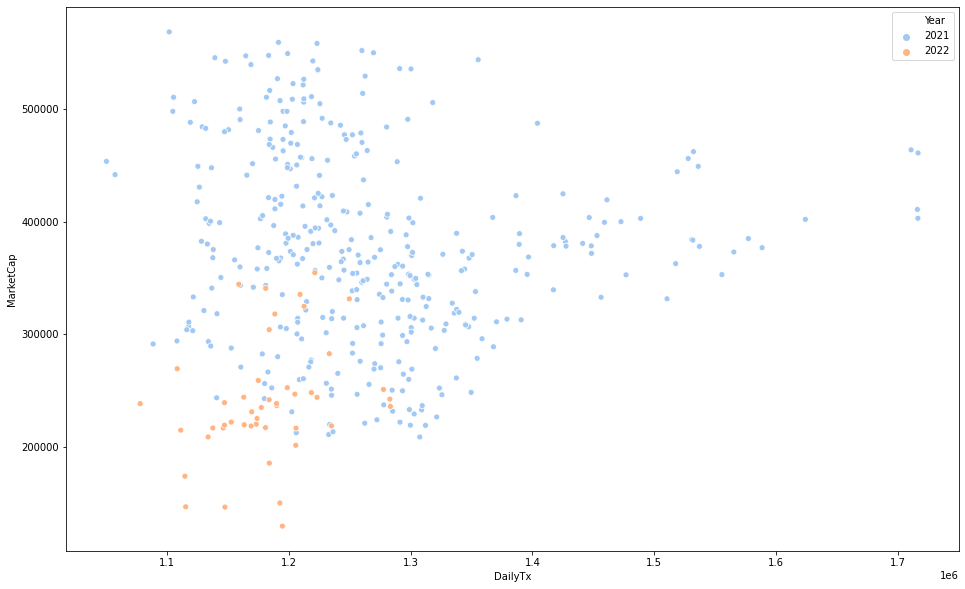

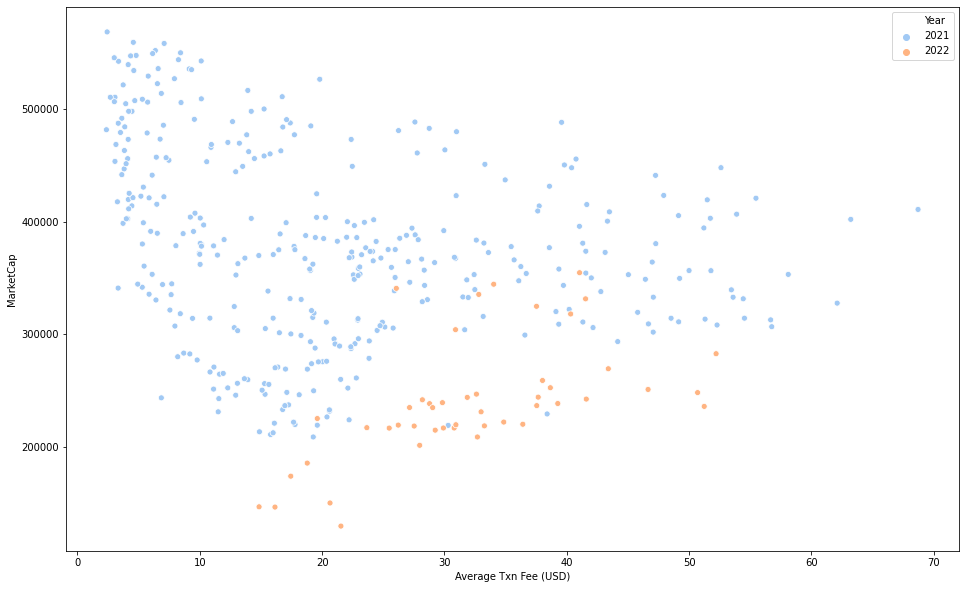

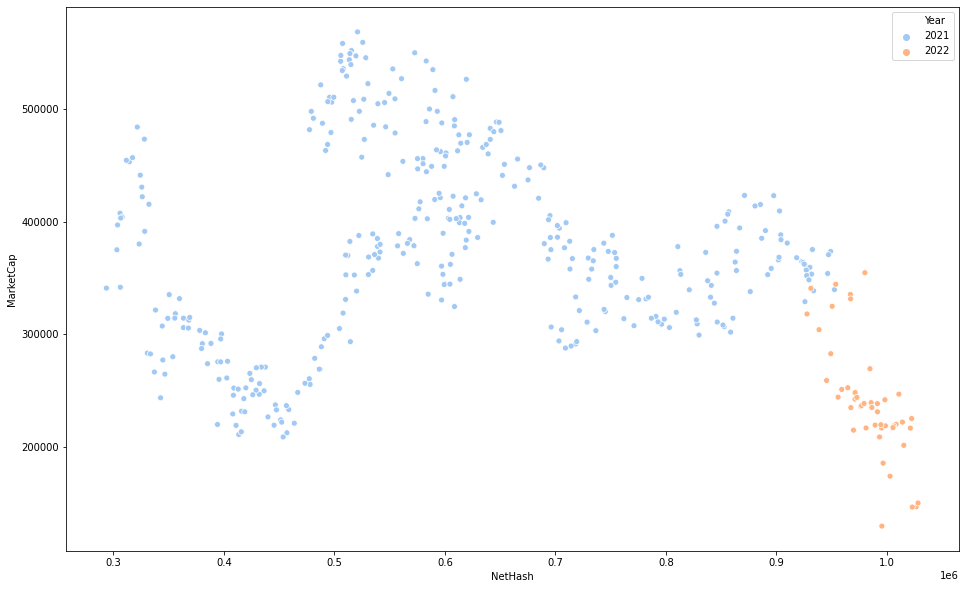

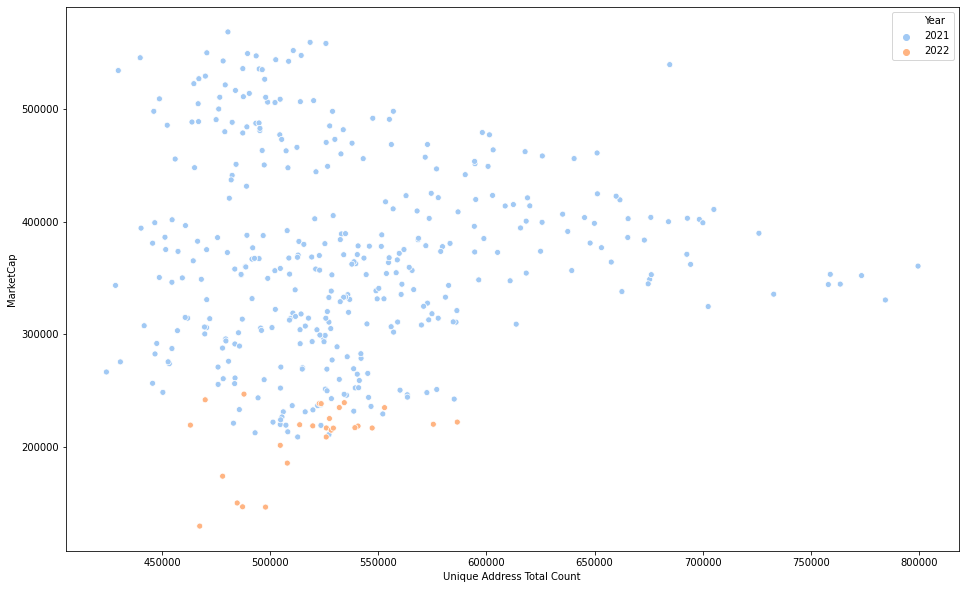

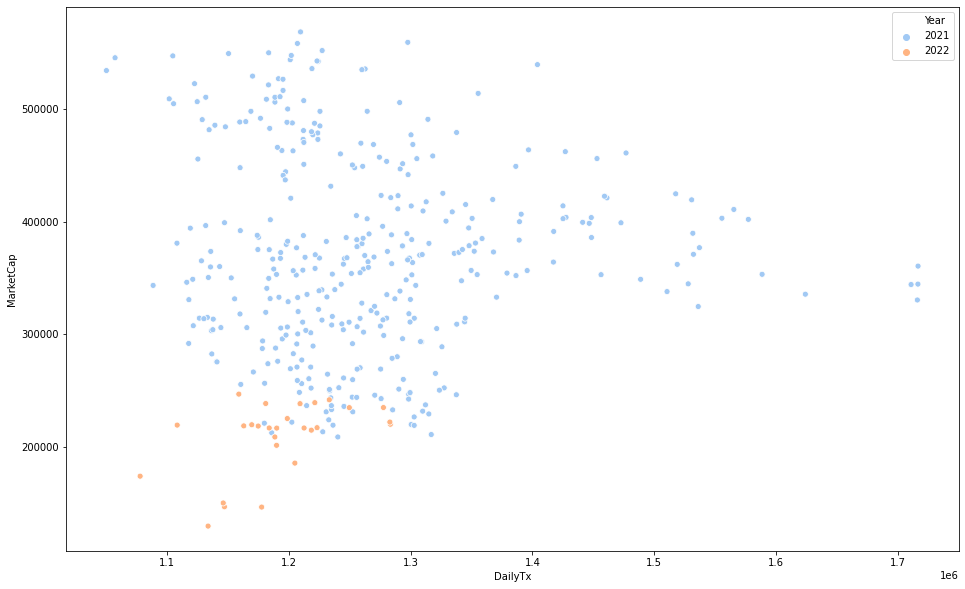

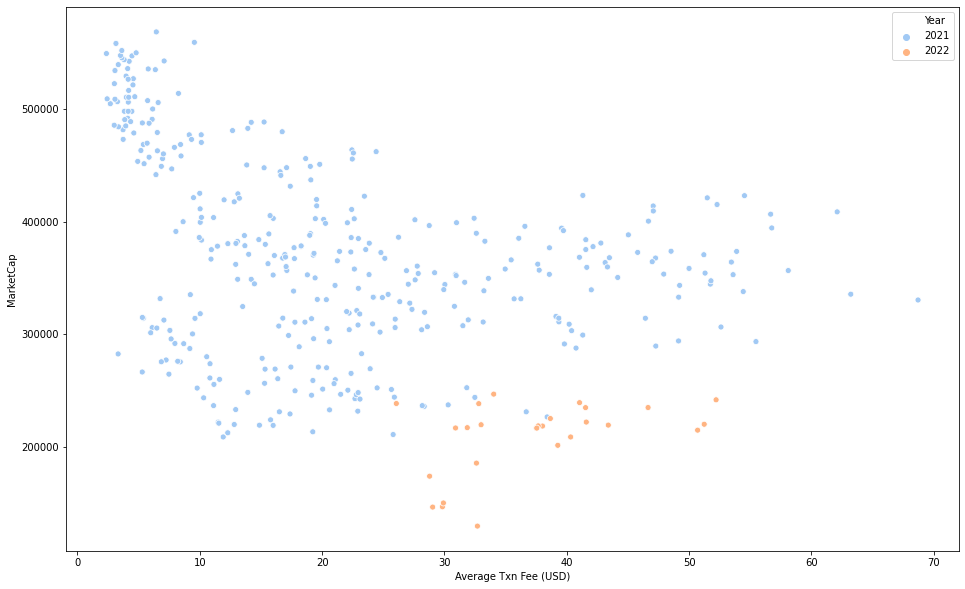

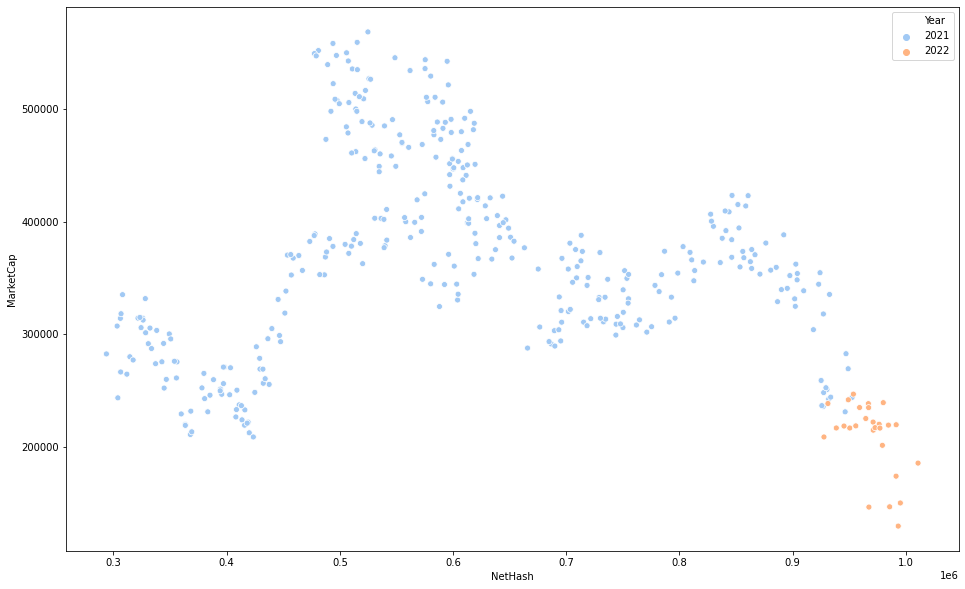

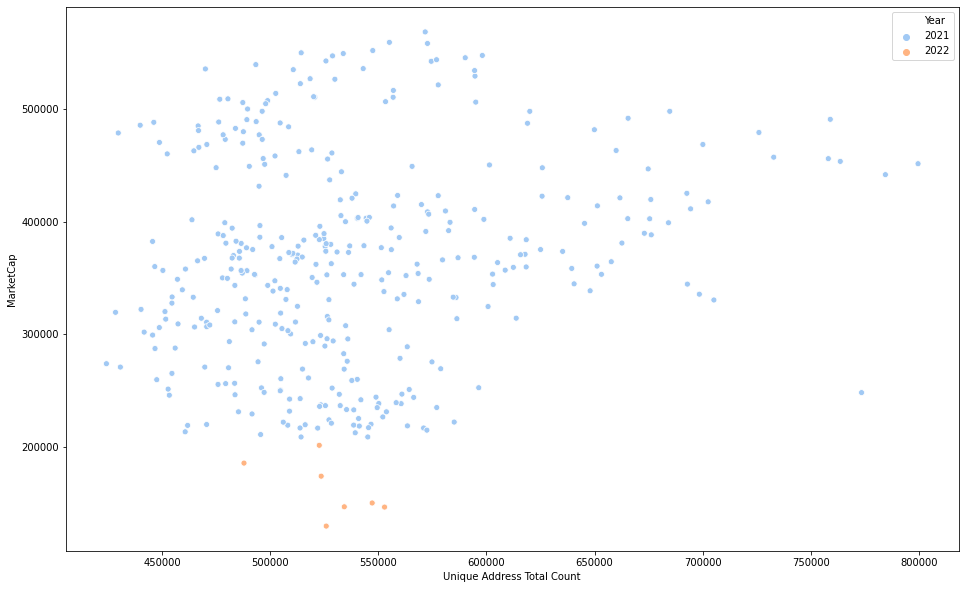

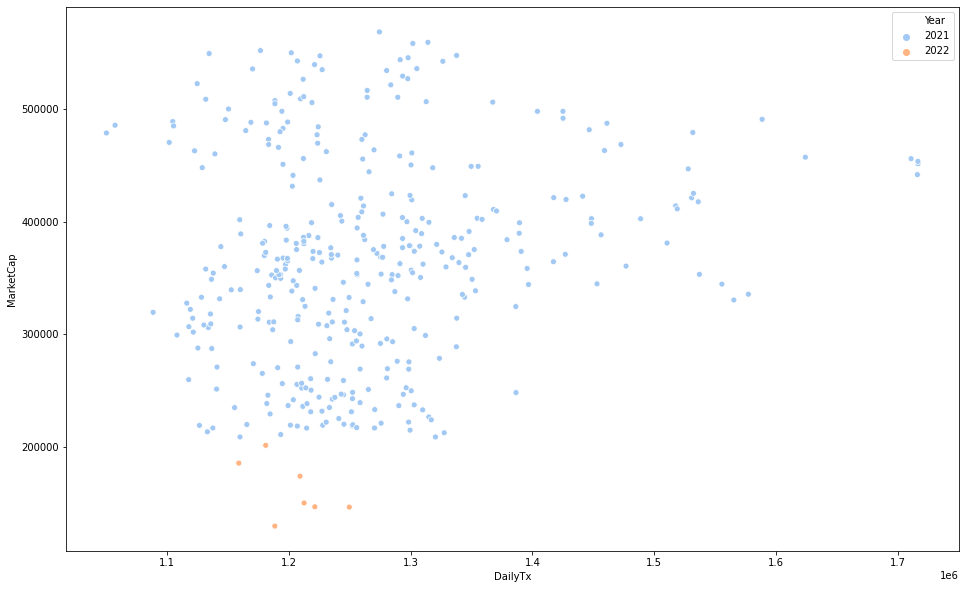

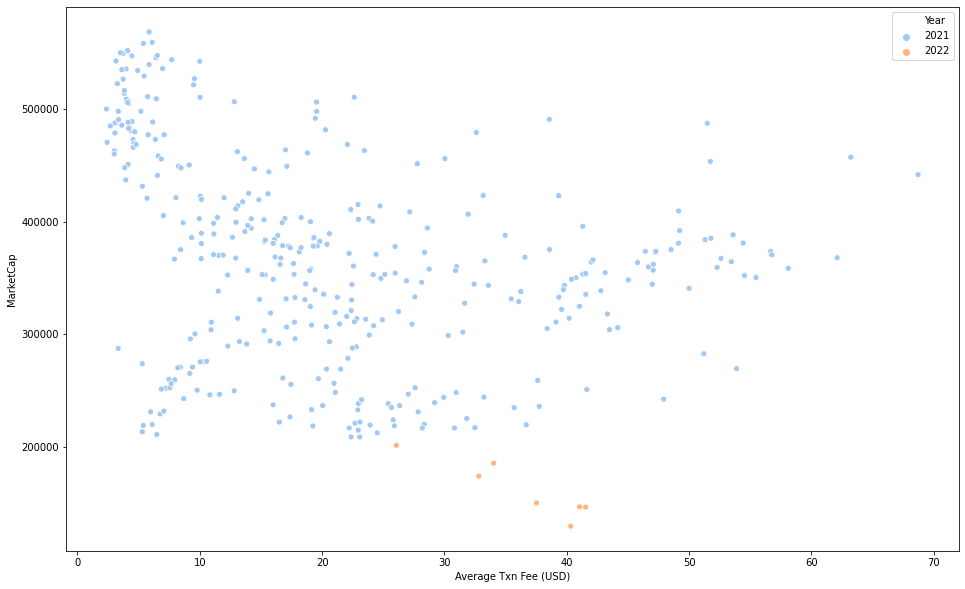

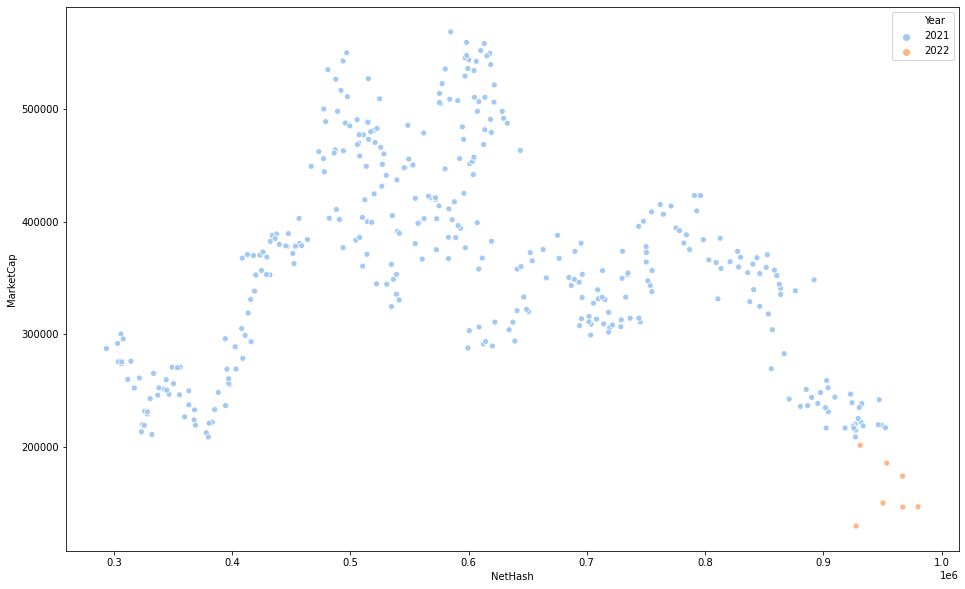

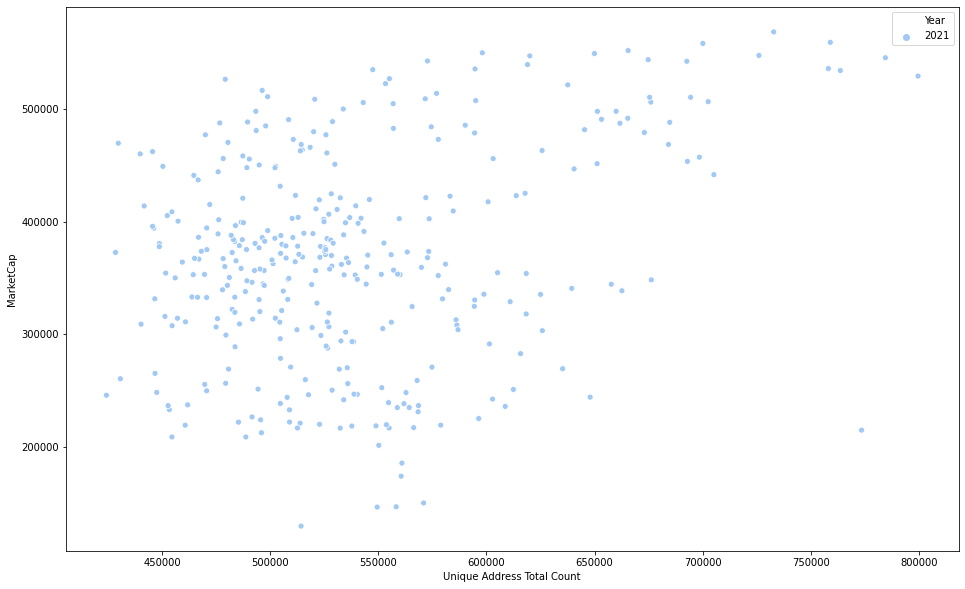

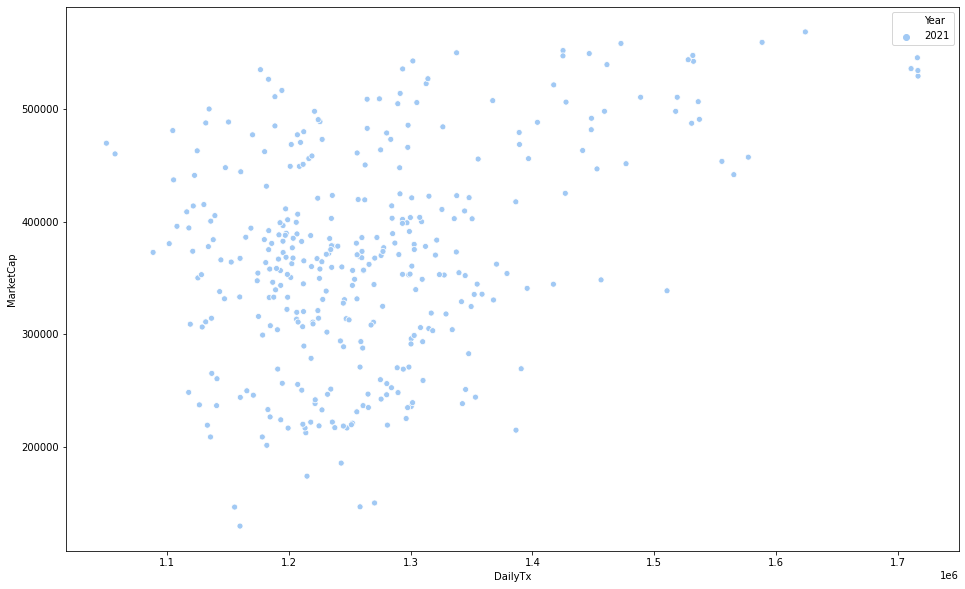

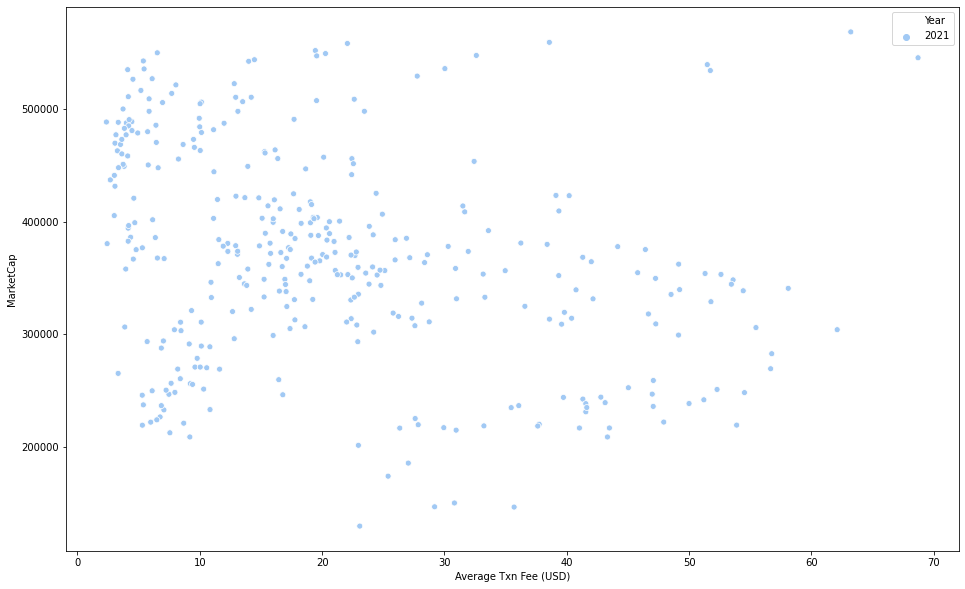

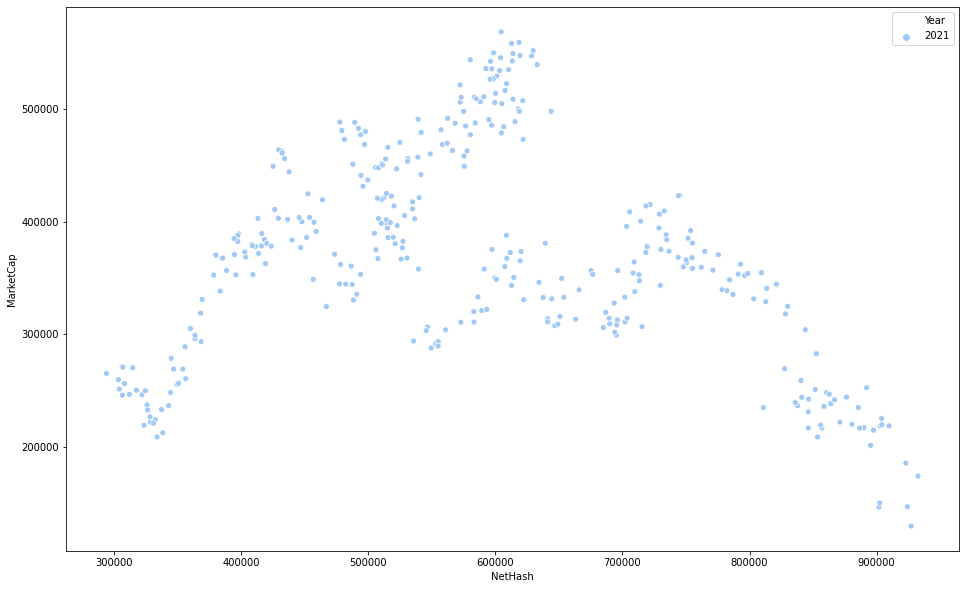

In [148]:
# 'sssd' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'
start_day = 0
end_day = 0
ss = -100
se = 300
# target_year = [2015,2022]
metrics = ["Unique Address Total Count", "DailyTx", "Average Txn Fee (USD)", 'NetHash']
n = 200
condition = target_year

target = frame.copy()
target["Year"] = target["Date(UTC)"].dt.year
target = target[target["Year"] > 2020]

# cur_frame = frame[frame['Date(UTC)'].dt.year == target_year[0]].concatenate(frame[frame['Date(UTC)'].dt.year == target_year[1]], axis = 1)
for i in range(0,n,20):
    for metric in metrics:
        fig, ax = plt.subplots(figsize=(16,10))
        sns.scatterplot(data = shift_((target),'MarketCap', i),ax=ax, x = metric, y = "MarketCap", hue="Year", palette="pastel")
        plot.set(xlabel=metric, ylabel='MarketCap', title=metric + ' to MarketCap shifted by ' +str(n) )
        name = 'plot_rcap/2020-2022/' + str(metric) +'_shifted_by_' + str(i)+ '.png'
        print(name)
        fig.savefig(name, transparent = False)
# arr.plot(kind = 'scatter', x='index', y=['Unique Address Total Count', 'NetHash', 'Average Txn Fee (USD)'])


In [134]:
target = frame.copy()
target["Year"] = target["Date(UTC)"].dt.year
target = target[target["Year"] > 2019]
# sns.scatterplot(data = target, x = "NetHash", y = "MarketCap", hue="Year", palette="pastel")

<AxesSubplot:xlabel='Unique Address Total Count', ylabel='MarketCap'>

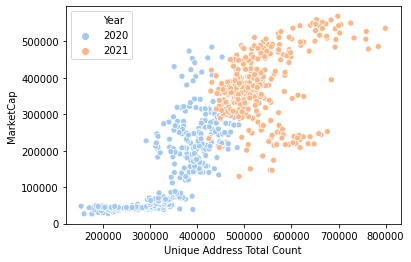

In [138]:
sns.scatterplot(data = shift_((target),'MarketCap', 200), x = "Unique Address Total Count", y = "MarketCap", hue="Year", palette="pastel")

<AxesSubplot:xlabel='NetHash', ylabel='MarketCap'>

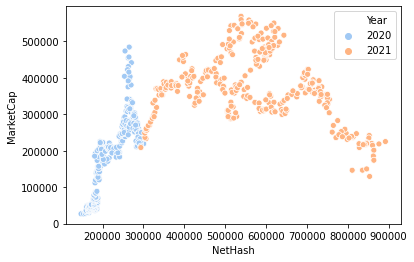

In [139]:
sns.scatterplot(data = shift_((target),'MarketCap', 200), x = "NetHash", y = "MarketCap", hue="Year", palette="pastel")

<AxesSubplot:xlabel='DailyTx', ylabel='MarketCap'>

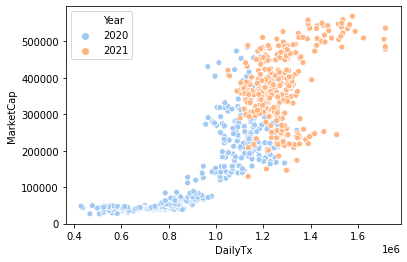

In [140]:
sns.scatterplot(data = shift_((target),'MarketCap', 200), x = "DailyTx", y = "MarketCap", hue="Year", palette="pastel")

In [19]:
# UnixTimeStamp	AddressCount	Unique Address Total Count	Unique Address Receive Count	Unique Address Sent Count	Supply	MarketCap	NetHash	DailyTx	Average Txn Fee (USD)	Average Txn Fee (Ether)	newAddressCount

<AxesSubplot:xlabel='Average Txn Fee (USD)', ylabel='MarketCap'>

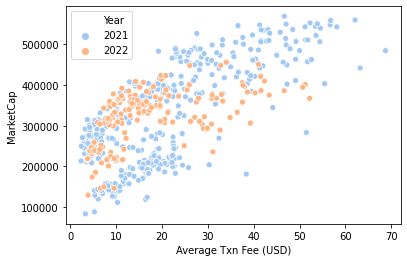

In [132]:
sns.scatterplot(data = target[target['Average Txn Fee (USD)'] < 100], x = "Average Txn Fee (USD)", y = "MarketCap", hue="Year", palette="pastel")

<AxesSubplot:xlabel='AddressCount', ylabel='MarketCap'>

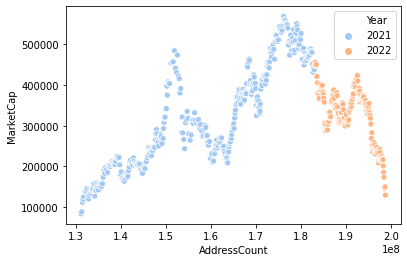

In [133]:
sns.scatterplot(data = target, x = "AddressCount", y = "MarketCap", hue="Year", palette="pastel")

In [22]:
target = frame.copy()
target["Year"] = target["Date(UTC)"].dt.year
target = target[target["Year"] > 2018]